In [ ]:
%run "Path to the setup.ipynb file"

importing standardlib modules
importing google drive
importing tensorflow/keras modules
importing miscelaneaous modules


In [ ]:
HOME_DIR = "Path to the project directory"
DATASET_PATH = "Path to the dataset files"
EMBEDDINGS_PATH = "Path to the embeddings"

data_params = {
    'emotions': ("surprise", "sadness", "neutral", "joy",
                 "fear", "disgust", "anger"),
    'n_emotions': 7,
    'n_conversations': 1374,
    'start_validation': 1030,
    'start_testing': 1202,
    'len_conversation': 24,
    'len_utterance': 40,
    'len_embedding': 1024
}

pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000)
rng = np.random.default_rng()

# Loading data into efficient format

In [ ]:
# @title convert conversations to single df
def get_conversation_df(data: DataFrame):
  conversations = data['conversation']
  global_id = 0
  dfs_with_index = []
  for conv_id, lst in enumerate(conversations):
      df = pd.DataFrame(lst)
      df['conversation_ID'] = conv_id
      df['global_ID'] = df['utterance_ID'].apply(lambda x: x + global_id)
      global_id += len(lst)
      dfs_with_index.append(df)
  conv_df = pd.concat(dfs_with_index, ignore_index=True)
  return conv_df

In [ ]:
# @title convert emotion-cause pairs to single df
def get_emotion_cause_pairs(data: DataFrame):
  ec_pairs = data['emotion-cause_pairs']
  dfs_with_index = []
  for i, lst in enumerate(ec_pairs):
      processed = [(int(e.split("_")[0]), e.split("_")[1],
                    int(c.split("_")[0]), c.split("_")[1]) for (e, c) in lst]
      df = pd.DataFrame(processed, columns=("emotion_utterance", "emotion_type",
                                            "cause_utterance", "cause_content"))
      df['conversation_ID'] = i
      dfs_with_index.append(df)
  pairs_df = pd.concat(dfs_with_index, ignore_index=True)
  return pairs_df

In [ ]:
data = pd.read_json(DATASET_PATH)
conv_df = get_conversation_df(data)
ec_pairs_df = get_emotion_cause_pairs(data)

# Loading data + encodings

In [ ]:
# @title Sample data/target batches

def load_batch_utterances(conversation_df: DataFrame,
               embeddings_path,
               batch_size: int = 32,
               validation: bool = False,
               testing: bool = False
               ):

  if validation and testing:
    raise ValueError("Can return either validation or testing data, not both")
    return

  # determin from which section to sample
  if validation:
    range_ = (data_params["start_validation"], data_params["start_testing"])
  elif testing:
    range_ = (data_params["start_testing"], data_params["n_conversations"])
  else:
    range_ = (0, data_params["start_validation"])

  conv_ind = np.arange(*range_)
  rng.shuffle(conv_ind)
  data = list()
  target = list()
  pbar = tqdm(total=batch_size)

  for index_selected in conv_ind:
    # load embeddings for data
    try:
        embeddings = np.load(embeddings_path + f"/conv_{index_selected}_embeddings.npy")
    except OSError:
      print("Embedding file not found or could not be read")
      return

    if len(embeddings) > batch_size - len(data):
      pbar.update(batch_size - len(data))
      data += [*embeddings[:batch_size - len(data)]]
    else:
      pbar.update(len(embeddings))
      data += [*embeddings]

    # load emotions for target
    emotions = conversation_df.loc[conversation_df["conversation_ID"] == index_selected]["emotion"].values
    emotions_one_hot = [tf.one_hot(data_params["emotions"].index(emotion), len(data_params["emotions"]))
        for emotion in emotions]
    target += emotions_one_hot[:batch_size - len(target)]

    if len(data) == batch_size:
      break

  if len(data) < batch_size:
      print("Requested batch size exceeds available data, " +
            f"max available {len(data)}")

  # utterances have identical shape and thus can be converted to np array
  data = np.array(data).squeeze(1)
  target = np.array(target)

  return data, target

In [ ]:
# @title Sample data/target batches

def load_batch_conversation(conversation_df: DataFrame,
                            ec_pairs_df: DataFrame,
                            embeddings_path: str,
                            batch_size: int = 1,
                            validation: bool = False,
                            testing: bool = False
                            ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, list]:

  if validation and testing:
    raise ValueError("Can return either validation or testing data, not both")
    return

  # determine from which section to sample
  if validation:
    range_ = (data_params["start_validation"], data_params["start_testing"])
  elif testing:
    range_ = (data_params["start_testing"], data_params["n_conversations"])
  else:
    range_ = (0, data_params["start_validation"])

  # generate sample indicies
  if batch_size > -np.subtract(*range_):
    print(f"Requested batch size exceeds available data, max available {-np.subtract(*range_)}")
    batch_size = -np.subtract(*range_)
  conv_ind = np.arange(*range_)
  rng.shuffle(conv_ind)

  conversations = list()
  emotions = list()
  causes = list()

  for index_selected in tqdm(conv_ind[:batch_size]):
    # load embeddings for data
    try:
        embeddings = np.load(embeddings_path + f"/conv_{index_selected}_embeddings.npy")
    except OSError:
      raise OSError(f"Embedding file conv_{index_selected}_embeddings.npy not found or could not be read")
      return

    # load emotions
    emotions_raw = conversation_df.loc[conversation_df["conversation_ID"] == index_selected]["emotion"].values
    emotions_one_hot = [tf.one_hot(data_params["emotions"].index(emotion), data_params["n_emotions"])
        for emotion in emotions_raw]

    # load causes
    causes_conv = ec_pairs_df.loc[ec_pairs_df["conversation_ID"] == index_selected]
    existing_causes = causes_conv[["emotion_utterance", "cause_utterance"]]
    cause_matrix = np.zeros((data_params["len_conversation"], data_params["len_conversation"]))
    for _, row in existing_causes.iterrows():
      if row["emotion_utterance"] < data_params["len_conversation"] and \
         row["cause_utterance"] < data_params["len_conversation"]:
        cause_matrix[row["emotion_utterance"]-1, row["cause_utterance"]-1] = 1

    # pad conversations with empty utterances
    if data_params["len_conversation"] > len(embeddings):
      len_padding = data_params["len_conversation"] - len(embeddings)

      emb_padding = np.zeros((len_padding, 1, 40, 1024))
      embeddings = np.append(embeddings, emb_padding, axis=0)

      emo_padding = tf.one_hot(np.repeat(2, len_padding), data_params["n_emotions"])
      emotions_one_hot = np.append(emotions_one_hot, emo_padding, axis=0)


    conversations.append(embeddings[:data_params["len_conversation"]])
    emotions.append(emotions_one_hot[:data_params["len_conversation"]])
    causes.append(cause_matrix.flatten())

  return (np.array(conversations).squeeze(2), np.array(emotions),
    np.array(causes), conv_ind[:batch_size])

# Data Analysis

In [ ]:
visualize = False

In [ ]:
# @title analyze utterances
def analyze_utterances(conv_df: DataFrame, axs: Sequence[plt.Axes]):
  words_per_utterance = conv_df["text"].apply(lambda s: len(s.split()))
  wpu = words_per_utterance.apply(lambda x: 41 if int(x) > 41 else x)
  utterances_per_conversation = conv_df["conversation_ID"].value_counts()
  upc = utterances_per_conversation.apply(lambda x: 25 if int(x) > 25 else x)

  print(f"There are {max(conv_df['conversation_ID']) + 1} conversations " +
        f"with an average of {np.mean(utterances_per_conversation):.2f} " +
        "utterances per conversation " +
        f"(std = {np.std(utterances_per_conversation):.2f})")
  print(f"{sum(utterances_per_conversation == 1)} conversations of length 1")
  print(f"{sum(utterances_per_conversation > 24)} conversations longer than 24")

  print(f"There are {max(conv_df['global_ID']) + 1} utterances total " +
        f"with an average of {np.mean(words_per_utterance):.2f} " +
        "words per utterances " +
        f"(std = {np.std(words_per_utterance):.2f})")

  axs[0].hist(upc, bins=range(1, 28, 2), density=True,
             color='skyblue', edgecolor='black')
  axs[0].set_xticks(ticks=range(2, 27, 2))
  axs[0].set_xticklabels([str(i*2) for i in range(1, 13)] + [">24"])
  axs[0].set_xlabel('Number of utterances (up to)')
  axs[0].set_yticks([])
  axs[0].set_ylabel('Frequency')
  axs[0].set_title('Utterances per conversation')
  axs[1].hist(wpu, bins=range(1, 46, 4), density=True,
             color='skyblue', edgecolor='black')
  axs[1].set_xticks(ticks=range(3, 44, 4))
  axs[1].set_xticklabels([str(i*4) for i in range(1, 11)] + [">40"])
  axs[1].set_xlabel('Number of words (up to)')
  axs[1].set_yticks([])
  axs[1].set_title('Words per utterance')
  plt.subplots_adjust(wspace=0.05, hspace=0)

  # plt.show()
  return axs

In [ ]:
# @title visualizing emotion distribution
def analyze_emotion_distribution(conv_df: DataFrame, ax: plt.Axes,
                                 show_neutral=True):
  data = conv_df.groupby('emotion').size()
  print(data)
  if not show_neutral:
    data = data.drop('neutral')
  # Plot histogram
  emos = ["neutral", "joy", "surprise", "anger", "sadness", "disgust", "fear"]
  emos_short = ["neu", "joy", "sur", "ang", "sad", "dis", "fear"]
  ax.bar(emos_short, data[emos], color='skyblue', edgecolor='black')
  ax.set_xlabel('Emotion')
  ax.set_yticks([])
  ax.set_title('Emotion distribution')
  return ax

In [ ]:
# @title emotion cause distance

def analyze_emotion_cause_distance(pairs_df: DataFrame, ax: plt.Axes):
  dist = pairs_df['emotion_utterance'] - pairs_df['cause_utterance']
  dist = dist.apply(lambda x: -3 if int(x) < -3 else x)
  dist = dist.apply(lambda x: 6 if int(x) > 6 else x)
  # Plot histogram
  ax.hist(dist, bins=range(-3,7), color='skyblue', edgecolor='black')

  # Add labels and title
  ax.set_xlabel('Distance between utterances')
  ax.set_xticks([i + 0.5 for i in range(-3,6)])
  ax.set_xticklabels(["<-2"] + list(range(-2,5)) + [">4"])
  ax.set_yticks([])
  ax.set_title('Emotion-cause distance')

  return ax

In [ ]:
# @title visualize causes per emotion
def analyze_causes_per_emotion(pairs_df: DataFrame, ax: plt.Axes):
  counts = pairs_df.groupby(['conversation_ID', 'emotion_utterance']
                            ).size().reset_index(name='count').groupby(["count"]
                                                                       ).size()

  counts[0] = 13620 - 5929 - counts.sum()
  # summarize counts larger than 5 in 5 bin
  for cpe in counts.keys():
    if int(cpe) > 5:
      counts[5] += counts[cpe]
      del counts[cpe]

  ax.bar(counts.keys(), counts, color='skyblue', edgecolor='black')
  # for i, count in zip(counts.keys(), counts):
  #   plt.text(i, count, str(count), ha='center', va='bottom')

  # Add labels and title
  ax.set_xlabel('Number of causes per emotion')
  ax.set_xticks(range(6))
  ax.set_xticklabels([0, 1, 2, 3, 4, ">4"])
  ax.set_yticks([])
  ax.set_title('Causes per emotion')

  return ax

There are 1374 conversations with an average of 9.91 utterances per conversation (std = 5.65)
41 conversations of length 1
2 conversations longer than 24
There are 13620 utterances total with an average of 11.24 words per utterances (std = 7.96)
emotion
anger       1615
disgust      414
fear         373
joy         2301
neutral     5929
sadness     1147
surprise    1840
dtype: int64


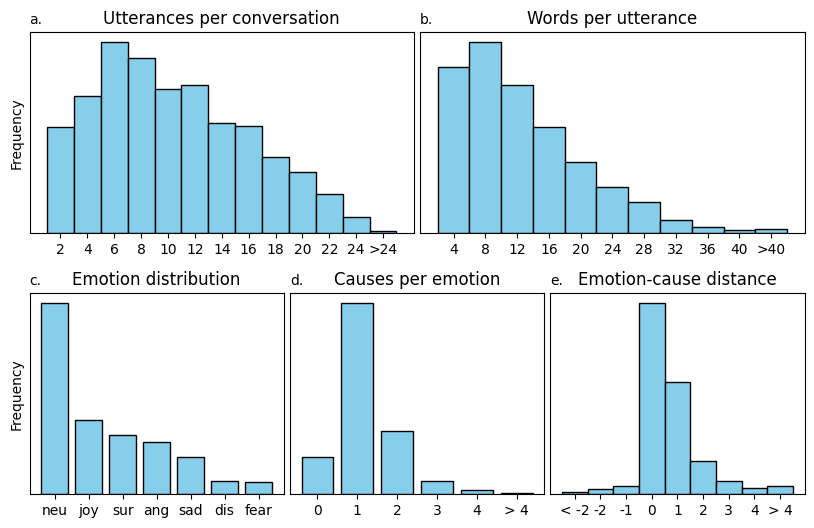

In [ ]:
if visualize:
  fig = plt.figure(figsize=(10, 6))

  gs = plt.GridSpec(2, 6, figure=fig, hspace=0.3)
  ax1 = fig.add_subplot(gs[0, :3])
  ax2 = fig.add_subplot(gs[0, 3:])
  ax3 = fig.add_subplot(gs[1, :2])
  ax4 = fig.add_subplot(gs[1, 2:4])
  ax5 = fig.add_subplot(gs[1, 4:])

  analyze_utterances(conv_df, [ax1, ax2])
  analyze_emotion_distribution(conv_df, ax3)
  ax3.set_ylabel('Frequency')
  analyze_causes_per_emotion(ec_pairs_df, ax4)
  analyze_emotion_cause_distance(ec_pairs_df, ax5)

  for n, a in enumerate([ax1, ax2, ax3, ax4, ax5]):
    # a.set_title("")
    a.set_title(chr(97+n) + ".", fontsize=10, loc="left")
    a.set_xlabel("")

  plt.show()



There are 1374 conversations with an average of 9.91 utterances per conversation (std = 5.65)
41 conversations of length 1
2 conversations longer than 24
There are 13620 utterances total with an average of 11.24 words per utterances (std = 7.96)


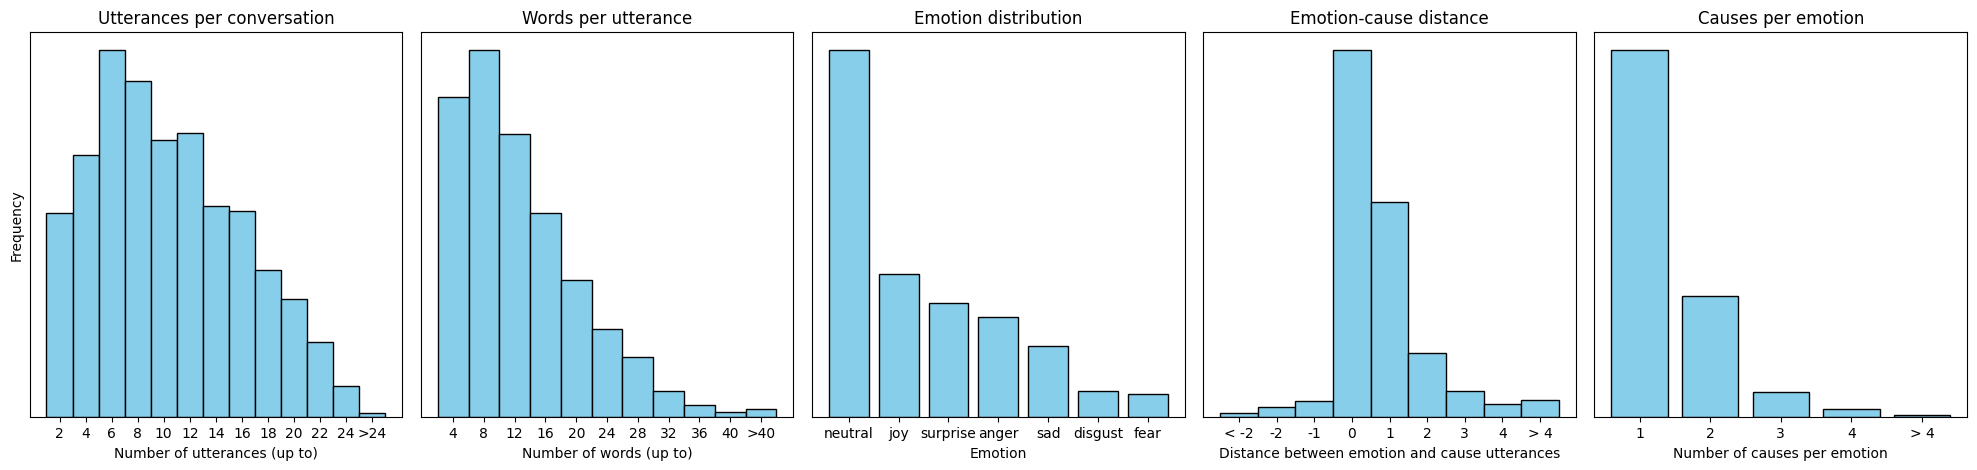

In [ ]:
if visualize:
  fig, axs = plt.subplots(1, 5, squeeze=True, figsize=(25, 5))
  analyze_utterances(conv_df, axs[:2])
  analyze_emotion_distribution(conv_df, axs[2])
  analyze_emotion_cause_distance(ec_pairs_df, axs[3])
  analyze_causes_per_emotion(ec_pairs_df, axs[4])
  plt.show()